In [1]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib



from steves_utils.summary_utils import (
    get_experiments_from_path
)

from steves_utils.utils_v2 import (
    get_experiments_base_path
)

In [2]:
experiments_to_get = [
    "cores-oracle.run1.framed",
    "oracle.run1.framed-oracle.run2.framed",
#     "cores-metehan",
    "wisig-oracle.run1.framed",
#     "oracle.run1-oracle.run2",
    "wisig-oracle.run1",
    "cores-wisig",
#     "wisig-metehan",
    "cores-oracle.run1",
#     "wisig-oracle.run1.limited",
#     "wisig-oracle.run1.limited"
]

experiments = {}

for experiment in experiments_to_get:
    print(experiment)
    experiments[experiment] = get_experiments_from_path(
        os.path.join(get_experiments_base_path(), "tl_1v2", experiment)
    )

cores-oracle.run1.framed
oracle.run1.framed-oracle.run2.framed
wisig-oracle.run1.framed
wisig-oracle.run1
cores-wisig
cores-oracle.run1
wisig-oracle.run1.limited
wisig-oracle.run1.limited


In [3]:
all_trials = pd.DataFrame(columns=[
    "experiment_name",
    "source_val_label_accuracy",
    "target_val_label_accuracy",
    "x_transform",
    "source_ds",
    "target_ds",
])

pickle_name_mapping = {
    "cores.stratified_ds.2022A.pkl": "cores",
    "metehan.stratified_ds.2022A.pkl": "metehan",
    "oracle.Run1_10kExamples_stratified_ds.2022A.pkl": "oracle.run1",
    "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl": "oracle.run1.framed",
    "oracle.Run2_10kExamples_stratified_ds.2022A.pkl": "oracle.run2",
    "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl": "oracle.run2.framed",
    "wisig.node3-19.stratified_ds.2022A.pkl": "wisig",
}

x_transform_mapping = {
    tuple(["unit_power"]):"Unit Power",
    tuple(["unit_mag"]): "Unit Magnitude",
    tuple([]): "None"
}

counter = 6

for experiment in experiments_to_get:   
    for trial in experiments[experiment]:
       
        datasets = trial["parameters"]["datasets"]
        assert len(datasets) == 2

        if datasets[0]["source_or_target_dataset"] == "source":
            source = datasets[0]
            target = datasets[1]
        else:
            target = datasets[0]
            source = datasets[1]
        
        source_name = os.path.basename(source["pickle_path"])
        target_name = os.path.basename(target["pickle_path"])
        
        source_name = pickle_name_mapping[source_name]
        target_name = pickle_name_mapping[target_name]
        
        
        assert source["x_transforms"] == target["x_transforms"]
        
        f = pd.DataFrame(trial["results"])
        f["experiment_name"] = experiment
        f["x_transform"] =  x_transform_mapping[tuple(source["x_transforms"])]
        f["source_ds"] = source_name
        f["target_ds"] = target_name
        f = f[all_trials.columns]
        
        f = f.iloc[0] # Unknown why, but pandas is repeating trials for each domain in the trial!
        
        
        all_trials = all_trials.append(f)
    
all_trials = all_trials.reset_index(drop=True)
all_trials

,experiment_name,source_val_label_accuracy,target_val_label_accuracy,x_transform,source_ds,target_ds
0,cores-oracle.run1.framed,0.890332,0.852939,Unit Magnitude,oracle.run1.framed,cores
1,cores-oracle.run1.framed,0.916927,0.934964,None,oracle.run1.framed,cores
2,cores-oracle.run1.framed,0.999358,0.291536,Unit Power,cores,oracle.run1.framed
3,cores-oracle.run1.framed,0.998714,0.271810,Unit Magnitude,cores,oracle.run1.framed
4,cores-oracle.run1.framed,0.998250,0.563867,None,cores,oracle.run1.framed
...,...,...,...,...,...,...
235,wisig-oracle.run1.limited,0.961498,0.115820,Unit Power,wisig,oracle.run1
236,wisig-oracle.run1.limited,0.963183,0.112598,Unit Power,wisig,oracle.run1
237,wisig-oracle.run1.limited,0.974284,0.285970,None,wisig,oracle.run1
238,wisig-oracle.run1.limited,0.969080,0.119596,Unit Magnitude,wisig,oracle.run1


In [4]:
all_trials["Transfer"] = all_trials["source_ds"] + "->" + all_trials["target_ds"]
all_trials

,experiment_name,source_val_label_accuracy,target_val_label_accuracy,x_transform,source_ds,target_ds,Transfer
0,cores-oracle.run1.framed,0.890332,0.852939,Unit Magnitude,oracle.run1.framed,cores,oracle.run1.framed->cores
1,cores-oracle.run1.framed,0.916927,0.934964,None,oracle.run1.framed,cores,oracle.run1.framed->cores
2,cores-oracle.run1.framed,0.999358,0.291536,Unit Power,cores,oracle.run1.framed,cores->oracle.run1.framed
3,cores-oracle.run1.framed,0.998714,0.271810,Unit Magnitude,cores,oracle.run1.framed,cores->oracle.run1.framed
4,cores-oracle.run1.framed,0.998250,0.563867,None,cores,oracle.run1.framed,cores->oracle.run1.framed
...,...,...,...,...,...,...,...
235,wisig-oracle.run1.limited,0.961498,0.115820,Unit Power,wisig,oracle.run1,wisig->oracle.run1
236,wisig-oracle.run1.limited,0.963183,0.112598,Unit Power,wisig,oracle.run1,wisig->oracle.run1
237,wisig-oracle.run1.limited,0.974284,0.285970,None,wisig,oracle.run1,wisig->oracle.run1
238,wisig-oracle.run1.limited,0.969080,0.119596,Unit Magnitude,wisig,oracle.run1,wisig->oracle.run1


In [5]:
m = pd.melt(all_trials, 
        id_vars=["Transfer", "x_transform"], 
        value_vars=[
            "source_val_label_accuracy",
            "target_val_label_accuracy",
        ])
m

,Transfer,x_transform,variable,value
0,oracle.run1.framed->cores,Unit Magnitude,source_val_label_accuracy,0.890332
1,oracle.run1.framed->cores,None,source_val_label_accuracy,0.916927
2,cores->oracle.run1.framed,Unit Power,source_val_label_accuracy,0.999358
3,cores->oracle.run1.framed,Unit Magnitude,source_val_label_accuracy,0.998714
4,cores->oracle.run1.framed,None,source_val_label_accuracy,0.998250
...,...,...,...,...
475,wisig->oracle.run1,Unit Power,target_val_label_accuracy,0.115820
476,wisig->oracle.run1,Unit Power,target_val_label_accuracy,0.112598
477,wisig->oracle.run1,None,target_val_label_accuracy,0.285970
478,wisig->oracle.run1,Unit Magnitude,target_val_label_accuracy,0.119596


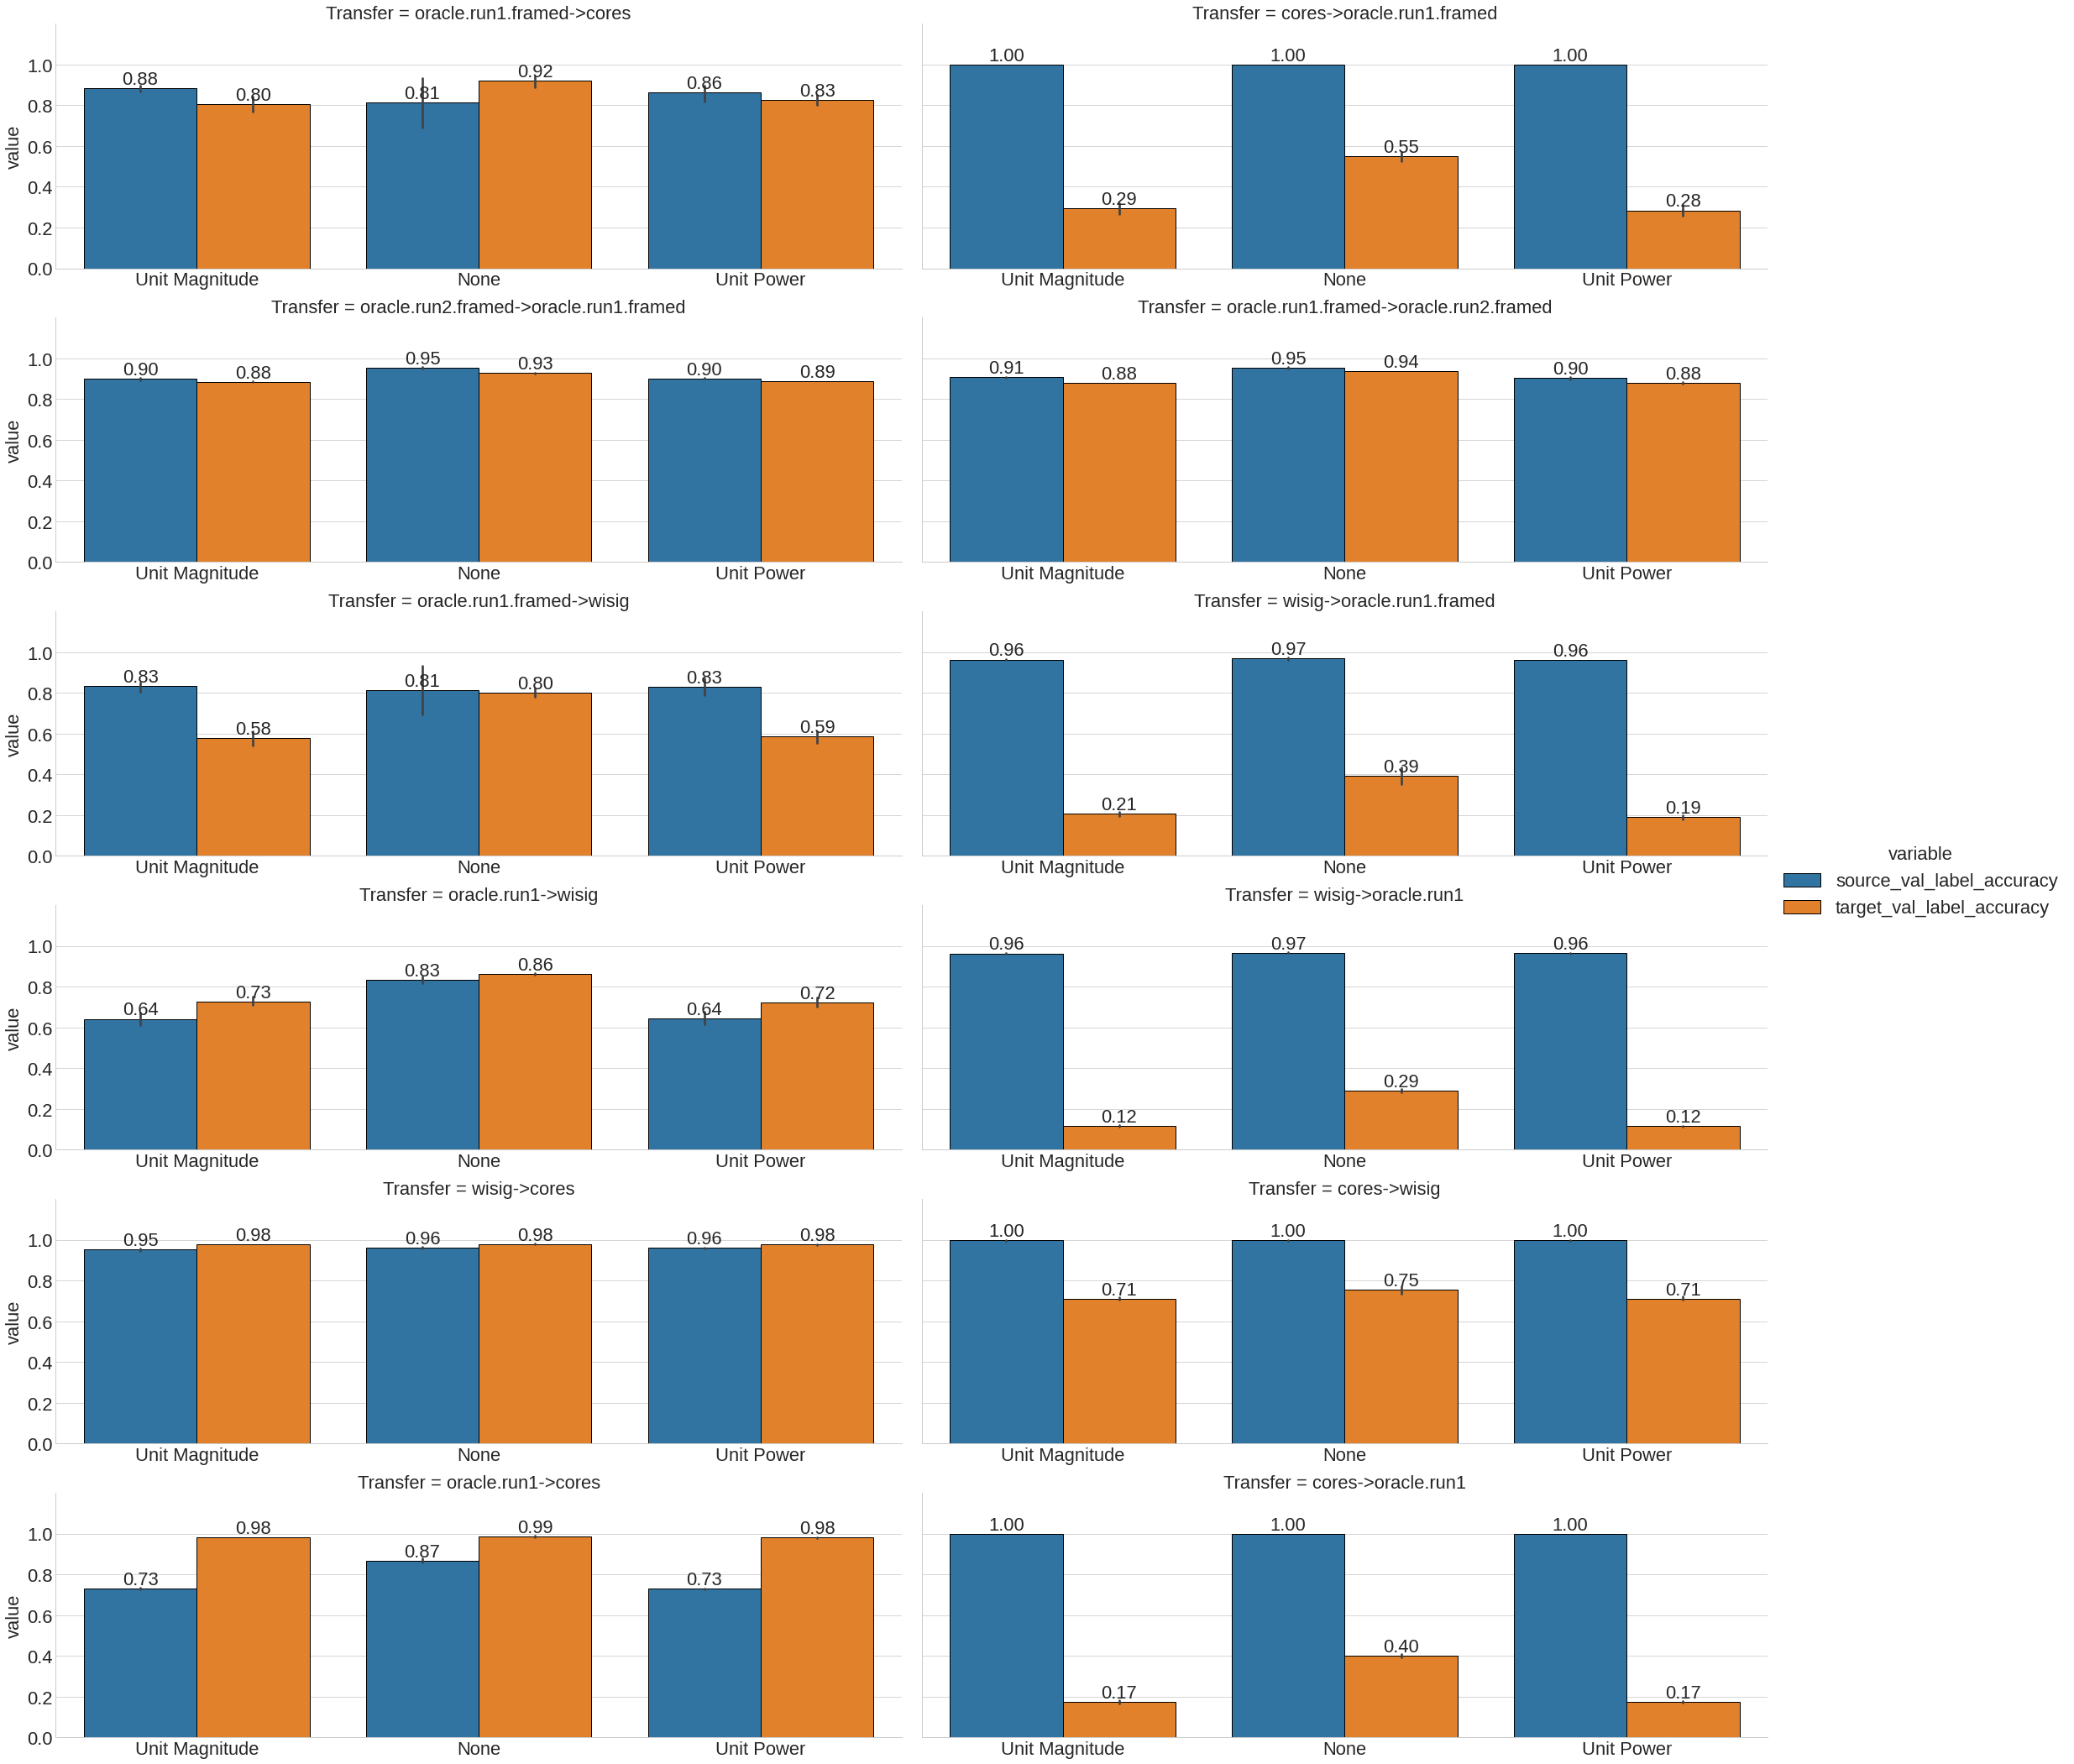

<Figure size 1080x3600 with 0 Axes>

In [6]:
matplotlib.rcParams.update({'font.size': 22})
plt.style.use('seaborn-whitegrid')

fg = sb.catplot(x='x_transform', col="Transfer", y='value', hue='variable', 
                        data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black")
fg.set_xlabels('')
plt.figure(figsize=(15,50))

# iterate through axes
for ax in fg.axes.ravel():
    
    ax.tick_params(labelbottom=True)
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)



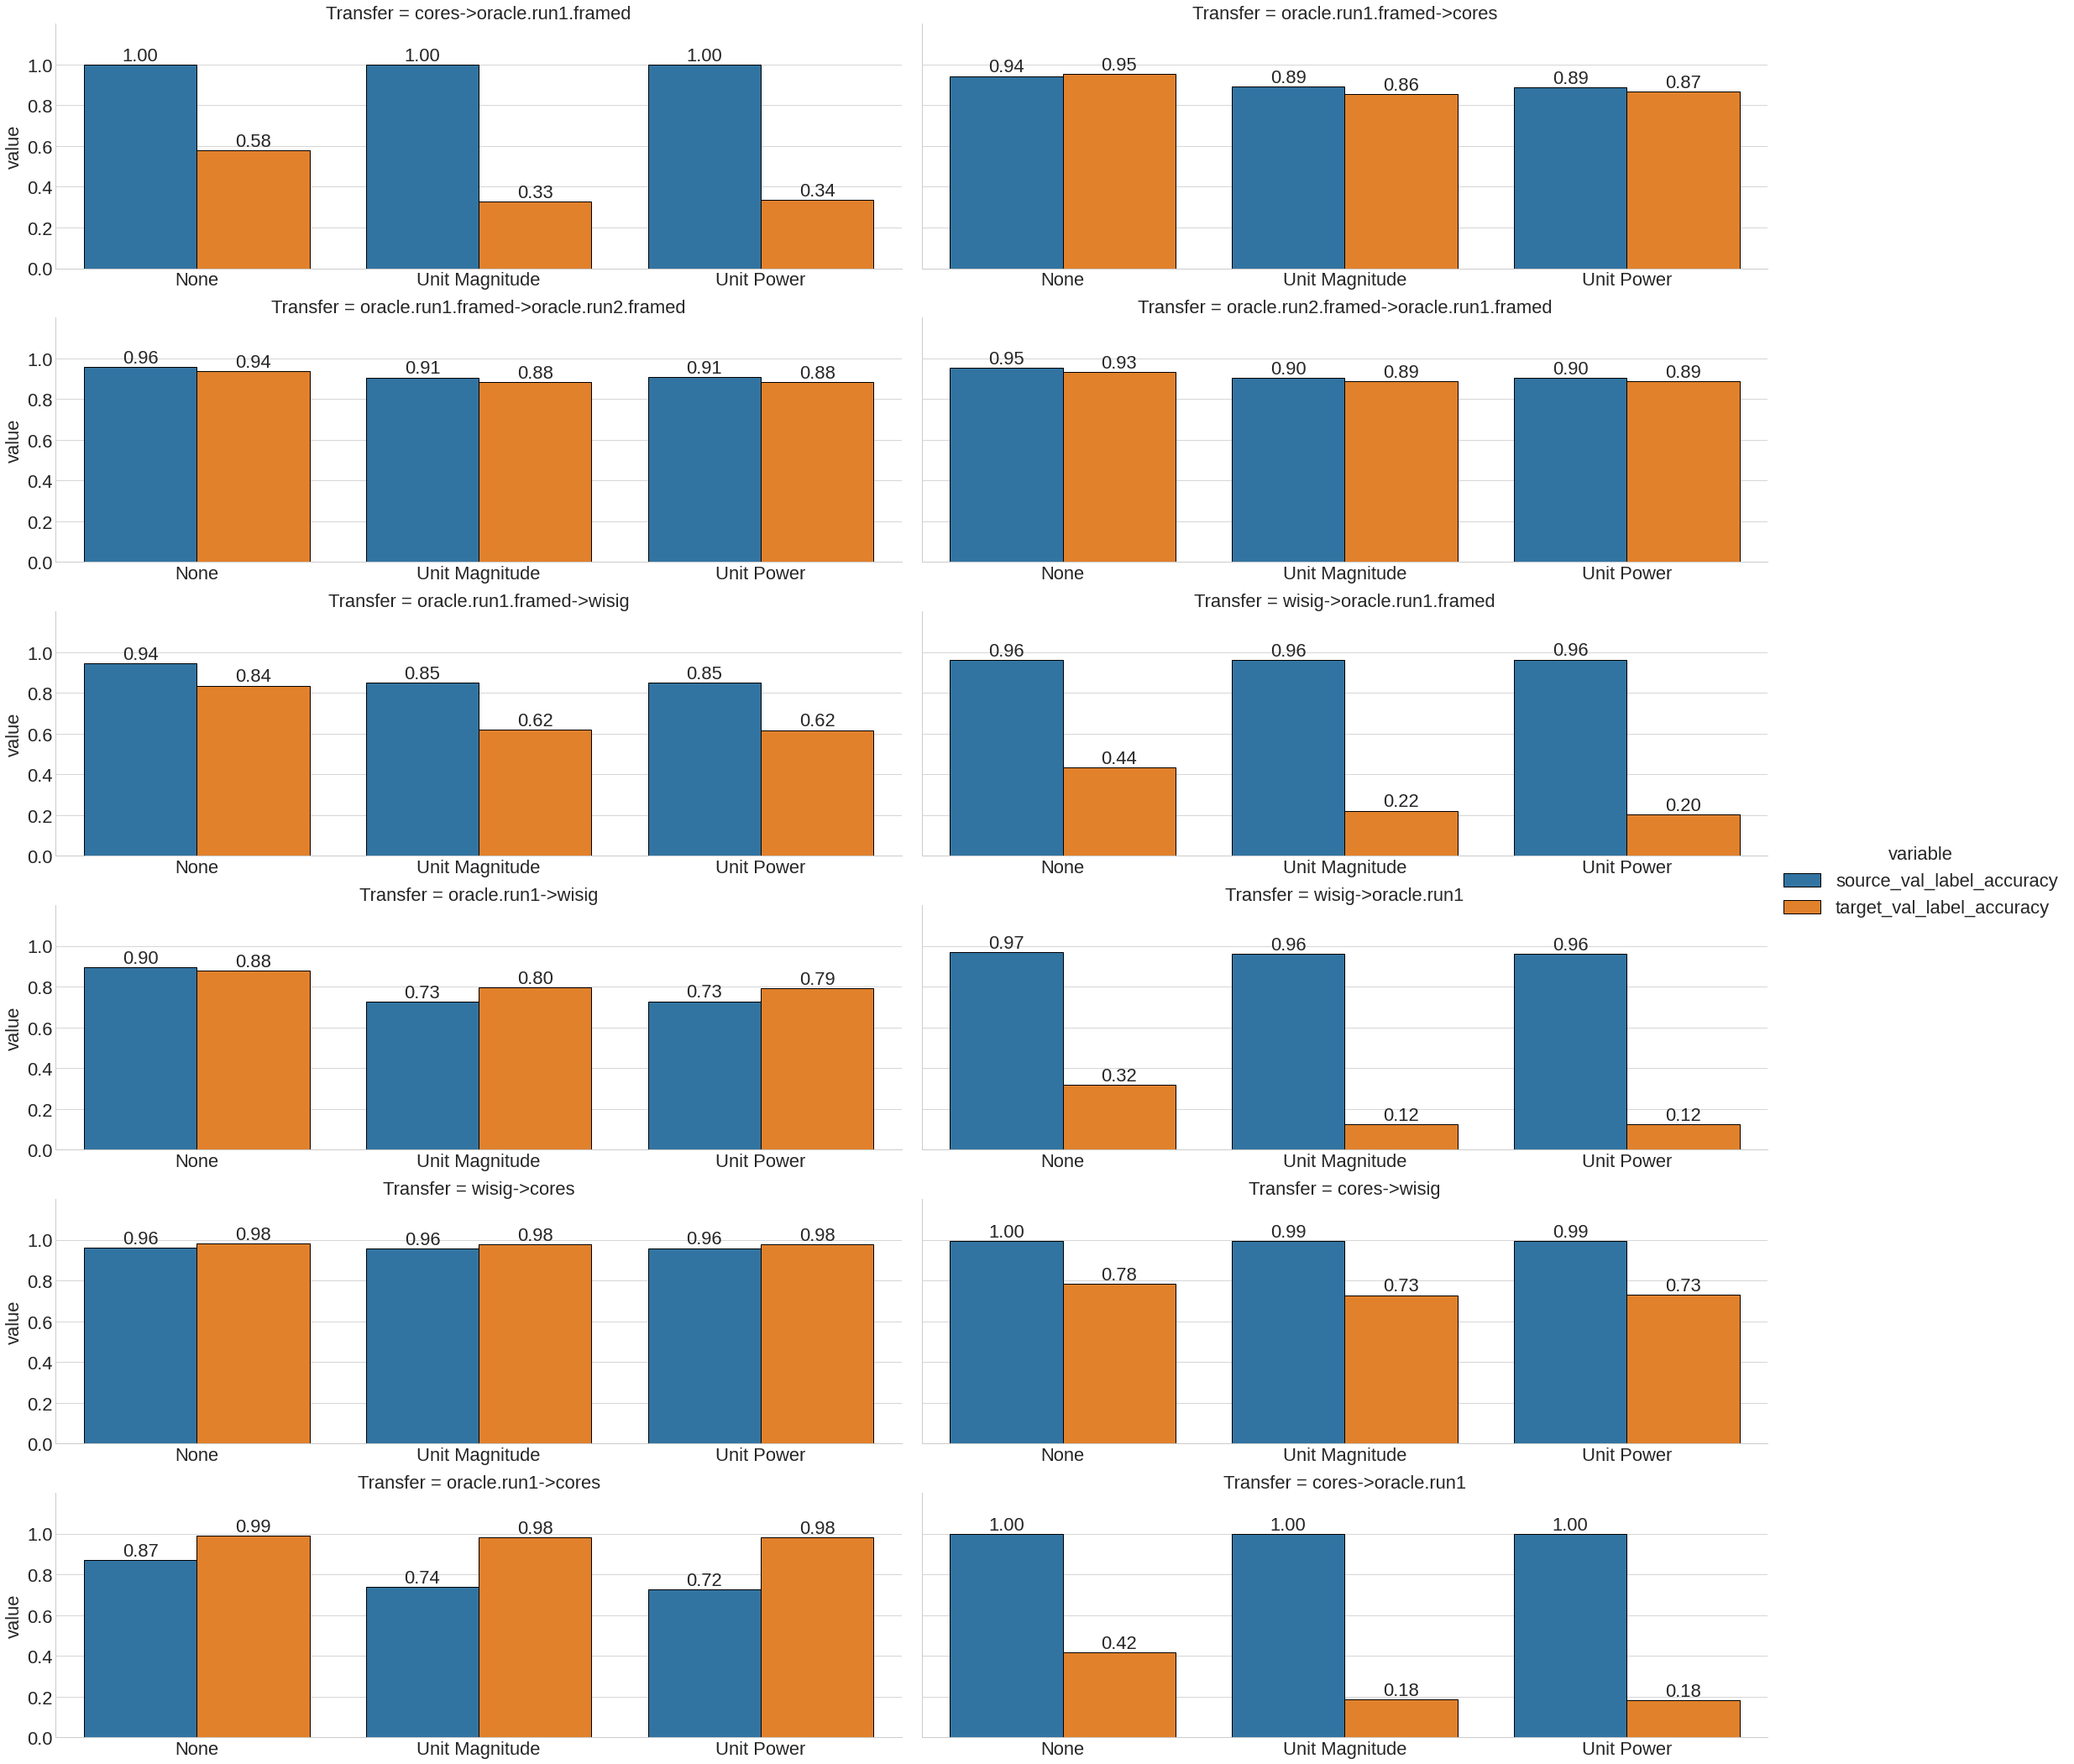

<Figure size 1080x3600 with 0 Axes>

In [7]:
# Pick the best trials based on target (on a per experiment+x_transform basis)
idx = all_trials.groupby(["Transfer", "x_transform"])["target_val_label_accuracy"].transform(max) == all_trials["target_val_label_accuracy"]
best = all_trials[idx]

m = pd.melt(best, 
        id_vars=["Transfer", "x_transform"], 
        value_vars=[
            "source_val_label_accuracy",
            "target_val_label_accuracy",
        ])

matplotlib.rcParams.update({'font.size': 22})
plt.style.use('seaborn-whitegrid')

fg = sb.catplot(x='x_transform', col="Transfer", y='value', hue='variable', 
                        data=m, kind='bar', height=5, aspect=3, col_wrap=2, edgecolor = "black")
fg.set_xlabels('')
plt.figure(figsize=(15,50))

# iterate through axes
for ax in fg.axes.ravel():
    
    ax.tick_params(labelbottom=True)
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)